<a href="https://colab.research.google.com/github/2019147517/RL/blob/main/sb/DQN-Breakout/DQN_Breakout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import IPython

In [ ]:
# HIDE OUTPUT
! wget http://www.atarimania.com/roms/Roms.rar
! mkdir /content/ROM/
! unrar e -o+ /content/Roms.rar /content/ROM/
! python -m atari_py.import_roms /content/ROM/
IPython.display.clear_output(wait=False)

In [ ]:
!git clone https://github.com/openai/baselines.git
%cd baselines
!pip install -e .
IPython.display.clear_output(wait=False)

In [ ]:
from baselines.common.atari_wrappers import make_atari, wrap_deepmind
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import deque, namedtuple
from itertools import count
import imageio
import base64

import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [ ]:
# Configuration paramaters for the whole setup
SEED = 42
GAMMA = 0.99  # Discount factor for past rewards
EPS_MIN = 0.1  # Minimum epsilon greedy parameter
EPS_MAX = 1.0  # Maximum epsilon greedy parameter
EPS_DECAY = 300000 # EPS_MIN after EPS_DECAY steps
BATCH_SIZE = 32  # Size of batch taken from replay buffer
MAX_STEPS_PER_EPISODE = 10000
WEIGHT_UPDATE_PER_EPOCH = 5000
# WEIGHT_UPDATE_PER_EPOCH = 500
TARGET_UPDATE = 10
NUM_EPOCHS = 1000
# NUM_EPOCHS = 10
MAX_MEMORY_LENGTH = 50000

In [ ]:
History = namedtuple('History',
                     ('state', 'action', 'next_state', 'reward'))

class ReplayMemory():
    def __init__(self, max_len):
        self.memory = deque([], maxlen=max_len)

    def push(self, *args):
        self.memory.append(History(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [ ]:
# Use the Baseline Atari environment because of Deepmind helper functions
env1 = make_atari("BreakoutNoFrameskip-v4")
# Warp the frames, grey scale, stake four frame and scale to smaller ratio
env = wrap_deepmind(env1, frame_stack=True, scale=True)
env.seed(SEED)

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[42, 742738649]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class DQN(nn.Module):
    def __init__(self, h, w, outputs):
        super().__init__()
        self.conv1 = nn.Conv2d(4, 32, 8, 4)
        self.conv2 = nn.Conv2d(32, 64, 4, 2)
        self.conv3 = nn.Conv2d(64, 64, 3, 1)

        def conv2d_size_out(size, kernel_size, stride):
            return (size - (kernel_size-1) - 1) // stride + 1
            
        conv1_w = conv2d_size_out(w, 8, 4)
        conv2_w = conv2d_size_out(conv1_w, 4, 2)
        conv3_w = conv2d_size_out(conv2_w, 3, 1)

        conv1_h = conv2d_size_out(h, 8, 4)
        conv2_h = conv2d_size_out(conv1_h, 4, 2)
        conv3_h = conv2d_size_out(conv2_h, 3, 1)

        linear_input_size = conv3_w * conv3_h * 64

        self.fc1 = nn.Linear(linear_input_size, 512)
        self.fc2 = nn.Linear(512, outputs)

    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc1(x.view(x.size(0), -1)))
        x = self.fc2(x)
        return x

In [ ]:
def select_action(state):
    global steps_done, Q_value, timestep
    sample = random.random()
    epsilon = max(EPS_MIN, EPS_MAX-(EPS_MAX - EPS_MIN)/EPS_DECAY*steps_done)
    steps_done += 1
    with torch.no_grad():
        action_prob = policy_net(state)

        Q_value = (Q_value*(timestep-1) + action_prob.max(1)[0].item())/timestep
        action = action_prob.max(1)[1].view(1, 1)

    if sample > epsilon:
        return action
    else:
        return torch.tensor([[random.randrange(num_actions)]], device=device,
                            dtype=torch.long)

In [ ]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    history = memory.sample(BATCH_SIZE)
    batch = History(*zip(*history))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)),
                                  device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    criterion = nn.HuberLoss()
    loss = criterion(state_action_values.float(), 
                     expected_state_action_values.unsqueeze(1).float())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:
def embed_mp4(filename):
    """Embeds an mp4 file in the notebook."""
    video = open(filename, 'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

    return IPython.display.HTML(tag)


def create_policy_eval_video(filename, num_episodes=5, train=False,
                    PATH='/content/drive/MyDrive/Colab Notebooks/model2.pt'):
    if not train:
        target_net.load_state_dict(torch.load(PATH))
        target_net.eval()

    filename = filename + ".mp4"
    with imageio.get_writer(filename, fps=30) as video:
        for _ in range(num_episodes):
            state = T.ToTensor()(np.array(env.reset())).unsqueeze(0)
            video.append_data(env1.render(mode='rgb_array'))
            done = False
            while not done:
                with torch.no_grad():
                    action = target_net(state).max(1)[1].view(1, 1)
                next_state, reward, done, etc = env.step(action.item())
                next_state =  T.ToTensor()(np.array(next_state)).unsqueeze(0)
                state = next_state
                video.append_data(env1.render(mode='rgb_array'))
    if train:
        return
    else:
        return embed_mp4(filename)

def plot_epoch_reward(epoch_avg_rewards, epoch_avg_Q):
    IPython.display.clear_output(wait=True)
    plt.clf()
    plt.figure(figsize = (8,4))
    plt.subplots_adjust(wspace=0.5)
    plt.subplot(1,2,1)
    plt.xlabel('Epoches')
    plt.ylabel('reward')
    plt.plot(np.arange(1, len(epoch_avg_rewards)+1), epoch_avg_rewards)

    plt.subplot(1,2,2)
    plt.xlabel('Epoches')
    plt.ylabel('Q value')
    plt.plot(np.arange(1, len(epoch_avg_Q)+1), epoch_avg_Q)
    plt.pause(0.001)

In [ ]:
state = np.array(env.reset())
height, width, frames = state.shape # (84, 84, 4)
num_actions = env.action_space.n # 4

policy_net = DQN(height, width, num_actions).to(device)
target_net = DQN(height, width, num_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=0.00025)

memory = ReplayMemory(MAX_MEMORY_LENGTH)

<Figure size 432x288 with 0 Axes>

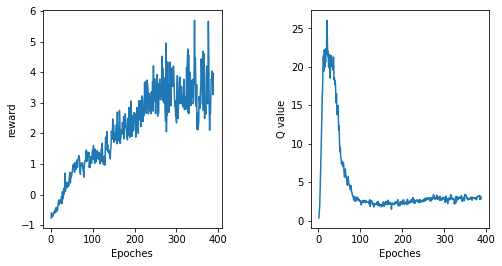

In [ ]:
epoch_avg_rewards, epoch_avg_Q = [], []

PATH='/content/drive/MyDrive/Colab Notebooks/'
VIDEO_PATH = 'video4/'
MODEL_PATH = 'model4.pt'
steps_done = 0

for epoch in range (1, NUM_EPOCHS+1):
    episode_rewards, episode_Q = [], []
    for episode in count():
        if steps_done // WEIGHT_UPDATE_PER_EPOCH >= epoch:
            break

        state = T.ToTensor()(np.array(env.reset())).unsqueeze(0)
        cum_rewards, Q_value = 0.0, 0.0

        for timestep in range(1, MAX_STEPS_PER_EPISODE):
            action = select_action(state)
            next_state, reward, done, _ = env.step(action.item())
            next_state = T.ToTensor()(np.array(next_state)).unsqueeze(0)

            optimize_model()
            if done:
                reward = -1.0
                next_state = None

            cum_rewards += reward
            reward = torch.tensor([reward], device=device)
            memory.push(state, action, next_state, reward)
            state = next_state

            if done:
                episode_rewards.append(cum_rewards)
                episode_Q.append(Q_value)
                break

        if steps_done % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())

    epoch_avg_rewards.append(sum(episode_rewards)/len(episode_rewards))
    epoch_avg_Q.append(sum(episode_Q)/len(episode_Q))
    torch.save(target_net.state_dict(), PATH+MODEL_PATH)
    plot_epoch_reward(epoch_avg_rewards, epoch_avg_Q)
    create_policy_eval_video(filename=PATH+VIDEO_PATH+str(epoch)+'epoch', train=True)